In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from nb_007a import *

# IMDB

## Fine-tuning the LM

Data has been prepared in csv files at the beginning 007a, we will use it know.

### Loading the data

In [ ]:
PATH = Path('../data/aclImdb/')
CLAS_PATH = PATH/'clas'
LM_PATH = PATH/'lm'
MODEL_PATH = PATH/'models'
os.makedirs(CLAS_PATH, exist_ok=True)
os.makedirs(LM_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

In [ ]:
tokenizer = Tokenizer(rules=rules, special_cases=[BOS, FLD, UNK, PAD])
train_ds, valid_ds = TextDataset.from_csv(LM_PATH, tokenizer, max_vocab=60000)

Numericalizing train.
Numericalizing valid.


In [ ]:
bs,bptt = 50,70
train_dl = LanguageModelLoader(np.concatenate(train_ds.ids), bs, bptt)
valid_dl = LanguageModelLoader(np.concatenate(valid_ds.ids), bs, bptt)

In [ ]:
data = DataBunch(train_dl, valid_dl)

### Adapt the pre-trained weights to the new vocabulary

Download the pretrained model and the corresponding itos dictionary here and put them in the MODEL_PATH folder.

In [ ]:
itos_wt = pickle.load(open(MODEL_PATH/'itos4.pkl', 'rb'))
stoi_wt = {v:k for k,v in enumerate(itos_wt)}

In [ ]:
#export
def convert_weights(wgts, stoi_wgts, itos_new):
    dec_bias, enc_wgts = wgts['1.decoder.bias'], wgts['0.encoder.weight']
    bias_m, wgts_m = dec_bias.mean(0), enc_wgts.mean(0)
    new_w = enc_wgts.new_zeros((len(itos_new),enc_wgts.size(1))).zero_()
    new_b = dec_bias.new_zeros((len(itos_new),)).zero_()
    for i,w in enumerate(itos_new):
        r = stoi_wgts[w] if w in stoi_wgts else -1
        new_w[i] = enc_wgts[r] if r>=0 else wgts_m
        new_b[i] = dec_bias[r] if r>=0 else bias_m
    wgts['0.encoder.weight'] = new_w
    wgts['0.encoder_dp.emb.weight'] = new_w.clone()
    wgts['1.decoder.weight'] = new_w.clone()
    wgts['1.decoder.bias'] = new_b
    return wgts

In [ ]:
wgts = torch.load(MODEL_PATH/'lstm4.pth', map_location=lambda storage, loc: storage)

In [ ]:
wgts['1.decoder.bias'][:10]

tensor([ 2.4323, -7.5824,  2.6640,  2.2581,  2.1299,  0.1094,  0.6768,  1.3353,
         1.7940,  0.8190])

In [ ]:
itos_wt[:10]

['xxunk', 'xxpad', 'the', ',', '.', '\n', 'of', 'and', 'in', 'to']

In [ ]:
wgts = convert_weights(wgts, stoi_wt, train_ds.vocab.itos)

In [ ]:
wgts['1.decoder.bias'][:10]

tensor([ 2.4323, -7.5824,  2.6640,  2.1299,  2.2581,  1.3353,  1.4665,  0.6768,
         0.8190, -0.9056])

In [ ]:
train_ds.vocab.itos[:10]

['xxunk', 'xxpad', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is']

## Define the model

In [ ]:
vocab_size = len(train_ds.vocab.itos)
emb_sz,nh,nl = 400,1150,3
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.3

In [ ]:
model = get_language_model(vocab_size, emb_sz, nh, nl, 0, input_p=dps[0], output_p=dps[1], weight_p=dps[2], 
                           embed_p=dps[3], hidden_p=dps[4])
model.load_state_dict(wgts)

Separation in different groups for discriminitative lr and gradual unfreezing.

In [ ]:
groups = [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].rnns, model[0].hidden_dps)] 
groups.append(nn.Sequential(model[0].encoder, model[0].encoder_dp, model[1]))

In [ ]:
learn = Learner(data, model)
learn.layer_groups = groups
learn.callbacks.append(RNNTrainer(learn, bptt, alpha=2, beta=1))
learn.metrics = [accuracy]
learn.freeze()

In [ ]:
lr_find(learn)

/home/ubuntu/anaconda3/envs/fastai1/lib/python3.7/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


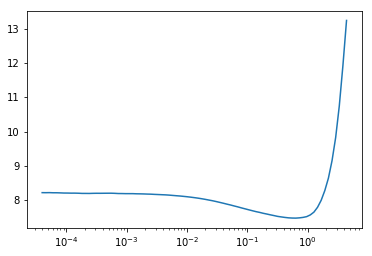

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 15:35
epoch  train loss  valid loss  accuracy
0      4.593133    4.463701    0.254175  (15:35)



In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7), pct_start=0.25)

Total time: 2:53:09
epoch  train loss  valid loss  accuracy
0      4.350517    4.251918    0.276182  (17:20)
1      4.229368    4.164854    0.287246  (17:17)
2      4.170904    4.116245    0.293109  (17:23)
3      4.086427    4.077303    0.297264  (17:23)
4      4.025311    4.049638    0.300450  (17:15)
5      3.937962    4.022684    0.303223  (17:22)
6      3.903079    4.001945    0.305667  (17:19)
7      3.848799    3.988719    0.307331  (17:15)
8      3.817554    3.980266    0.308544  (17:13)
9      3.864249    3.978115    0.308649  (17:17)



In [ ]:
learn.save('fine_tuned60kb')

In [ ]:
learn.load('fine_tuned60kb')

In [ ]:
#export
def save_encoder(learn, name):
    torch.save(learn.model[0].state_dict(), learn.path/f'{name}.pth')

In [ ]:
save_encoder(learn, 'fine_tuned_enc60kb')

## Classifier

We need to use the same itos than the language model.

In [ ]:
os.makedirs(CLAS_PATH/'tmp', exist_ok=True)
shutil.copy(LM_PATH/'tmp'/'itos.pkl', CLAS_PATH/'tmp'/'itos.pkl')

PosixPath('../data/aclImdb/clas/tmp/itos.pkl')

In [ ]:
vocab = Vocab(CLAS_PATH/'tmp')
tokenizer = Tokenizer(rules=rules, special_cases=[BOS, FLD, UNK, PAD])
train_ds, valid_ds = TextDataset.from_csv(CLAS_PATH, tokenizer, vocab=vocab)

Numericalizing train.
Numericalizing valid.


In [ ]:
train_ds.vocab.itos[:20], vocab.itos[:20]

(['xxunk',
  'xxpad',
  'the',
  '.',
  ',',
  'and',
  'a',
  'of',
  'to',
  'is',
  'it',
  'in',
  'i',
  'this',
  'that',
  '"',
  "'s",
  '-',
  '\n\n',
  'was'],
 ['xxunk',
  'xxpad',
  'the',
  '.',
  ',',
  'and',
  'a',
  'of',
  'to',
  'is',
  'it',
  'in',
  'i',
  'this',
  'that',
  '"',
  "'s",
  '-',
  '\n\n',
  'was'])

In [ ]:
train_ds.vocab.textify(train_ds.ids[1]), train_ds.labels[1]

('\n xxbos xxfld 1 " match point " and now " scoop " have both convinced me that not only is woody allen doing a neat job making movies in england ( and that scarlett johansson is the right cast member ) , but corroborated what i have known for years : he should n\'t focus on neurotic rich new yorkers . in this case , johansson plays journalism student sondra pransky , whom magician sid waterman ( allen ) puts in his disappearing box , where she meets the ghost of murdered reporter joe strombel ( ian mcshane ) , who tells her that the serial killings that have plagued london were committed by millionaire peter lyman ( hugh jackman ) . so , she gets to know him , and ... well , i do n\'t know how much i can tell you without giving it away . but i can say that this is probably allen \'s funniest movie in years . there \'s his ubiquitous unique style of humor ( especially the line about his religion ) . \n\n so , you \'re sure to like this movie . if nothing else , it \'ll make you fall i

In [ ]:
#export
from torch.utils.data import Sampler, BatchSampler

class SortSampler(Sampler):
    "Go through the text data by order of length"
    
    def __init__(self, data_source, key): self.data_source,self.key = data_source,key
    def __len__(self): return len(self.data_source)
    def __iter__(self):
        return iter(sorted(range(len(self.data_source)), key=self.key, reverse=True))


class SortishSampler(Sampler):
    "Go through the text data by order of length with a bit of randomness"
    
    def __init__(self, data_source, key, bs):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self): return len(self.data_source)

    def __iter__(self):
        idxs = np.random.permutation(len(self.data_source))
        sz = self.bs*50
        ck_idx = [idxs[i:i+sz] for i in range(0, len(idxs), sz)]
        sort_idx = np.concatenate([sorted(s, key=self.key, reverse=True) for s in ck_idx])
        sz = self.bs
        ck_idx = [sort_idx[i:i+sz] for i in range(0, len(sort_idx), sz)]
        max_ck = np.argmax([self.key(ck[0]) for ck in ck_idx])  # find the chunk with the largest key,
        ck_idx[0],ck_idx[max_ck] = ck_idx[max_ck],ck_idx[0]     # then make sure it goes first.
        sort_idx = np.concatenate(np.random.permutation(ck_idx[1:]))
        sort_idx = np.concatenate((ck_idx[0], sort_idx))
        return iter(sort_idx)

In [ ]:
#export
def pad_collate(samples, pad_idx=1, pad_first=True):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(max_len, len(samples)).long() + pad_idx
    for i,s in enumerate(samples): res[-len(s[0]):,i] = LongTensor(s[0])
    return res, LongTensor([s[1] for s in samples]).squeeze()

In [ ]:
train_sampler = SortishSampler(train_ds.ids, key=lambda x: len(train_ds.ids[x]), bs=bs//2)
valid_sampler = SortSampler(valid_ds.ids, key=lambda x: len(valid_ds.ids[x]))
train_dl = DeviceDataLoader.create(train_ds, bs//2, sampler=train_sampler, collate_fn=pad_collate)
valid_dl = DeviceDataLoader.create(valid_ds, bs,  sampler=valid_sampler, collate_fn=pad_collate)
data = DataBunch(train_dl, valid_dl)

In [ ]:
x,y = next(iter(train_dl))

In [ ]:
vocab.textify(x[:,15]), y[2]

("xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx

In [ ]:
#export
class MultiBatchRNNCore(RNNCore):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        self.max_seq,self.bptt = max_seq,bptt
        super().__init__(*args, **kwargs)

    def concat(self, arrs):
        return [torch.cat([l[si] for l in arrs]) for si in range(len(arrs[0]))]

    def forward(self, input):
        sl,bs = input.size()
        self.reset()
        raw_outputs, outputs = [],[]
        for i in range(0, sl, self.bptt):
            r, o = super().forward(input[i: min(i+self.bptt, sl)])
            if i>(sl-self.max_seq):
                raw_outputs.append(r)
                outputs.append(o)
        return self.concat(raw_outputs), self.concat(outputs)

In [ ]:
#export
def bn_dp_lin(n_in, n_out, drop, relu=True): 
    layers = [nn.BatchNorm1d(n_in), nn.Dropout(drop), nn.Linear(n_in, n_out)]
    if relu: layers.append(nn.ReLU(inplace=True))
    return layers

In [ ]:
#export
class PoolingLinearClassifier(nn.Module):
    def __init__(self, layers, drops):
        super().__init__()
        lyrs = []
        for i in range(len(layers)-1):
            lyrs += bn_dp_lin(layers[i], layers[i + 1], drops[i], i!=len(layers)-2)
        self.layers = nn.Sequential(*lyrs)

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)

    def forward(self, input):
        raw_outputs, outputs = input
        output = outputs[-1]
        sl,bs,_ = output.size()
        avgpool = self.pool(output, bs, False)
        mxpool = self.pool(output, bs, True)
        x = torch.cat([output[-1], mxpool, avgpool], 1)
        x = self.layers(x)
        return x, raw_outputs, outputs

In [ ]:
#export
def get_rnn_classifier(bptt, max_seq, n_class, vocab_sz, emb_sz, n_hid, n_layers, pad_token, layers, drops, 
                       bidir=False, qrnn=False, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5):
    rnn_enc = MultiBatchRNNCore(bptt, max_seq, vocab_sz, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      qrnn=qrnn, hidden_p=hidden_p, input_p=input_p, embed_p=embed_p, weight_p=weight_p)
    return SequentialRNN(rnn_enc, PoolingLinearClassifier(layers, drops))

In [ ]:
vocab_size,n_class = len(train_ds.vocab.itos),2
emb_sz,nh,nl = 400,1150,3
#dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [ ]:
model = get_rnn_classifier(bptt, 20*70, n_class, vocab_size, emb_sz=emb_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[emb_sz*3, 50, n_class], drops=[dps[1], 0.1],
          input_p=dps[0], weight_p=dps[2], embed_p=dps[3], hidden_p=dps[4])

In [ ]:
groups = [nn.Sequential(model[0].encoder, model[0].encoder_dp)]
groups += [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].rnns, model[0].hidden_dps)] 
groups.append(model[1])

In [ ]:
model[1]

PoolingLinearClassifier(
  (layers): Sequential(
    (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.25)
    (2): Linear(in_features=1200, out_features=50, bias=True)
    (3): ReLU(inplace)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [ ]:
learn = Learner(data, model)
learn.layer_groups = groups
learn.callbacks.append(RNNTrainer(learn, bptt, alpha=2, beta=1, adjust=False))
learn.callback_fns.append(partial(GradientClipping, clip=0.12))
learn.metrics = [accuracy]
learn.freeze()

In [ ]:
#export
def load_encoder(learn, name):
    learn.model[0].load_state_dict(torch.load(learn.path/f'{name}.pth'))

In [ ]:
load_encoder(learn, 'fine_tuned_enc60ka')

In [ ]:
learn.lr_find()

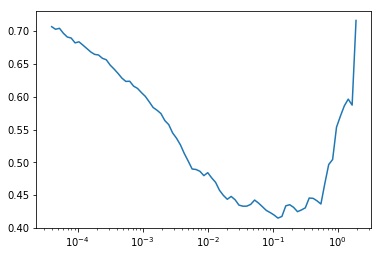

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:20
epoch  train loss  valid loss  accuracy
0      0.299096    0.197297    0.924520  (02:20)



In [ ]:
learn.save('first')

In [ ]:
learn.load('first')

In [ ]:
lr=1e-2
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lrs, moms=(0.8,0.7), pct_start=0.1)

Total time: 02:43
epoch  train loss  valid loss  accuracy
0      0.264912    0.167870    0.937400  (02:43)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second')

In [ ]:
lr=5e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, lrs, moms=(0.8,0.7), pct_start=0.1)

Total time: 04:03
epoch  train loss  valid loss  accuracy
0      0.223868    0.151519    0.945080  (04:03)



In [ ]:
learn.save('third')

In [ ]:
learn.load('third')

In [ ]:
lr=1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lrs, moms=(0.8,0.7), pct_start=0.1)

Total time: 10:31
epoch  train loss  valid loss  accuracy
0      0.133141    0.167304    0.946960  (05:15)
1      0.127248    0.171328    0.947680  (05:16)

